In [1]:
import os
import glob
import pandas as pd
import plotly.express as px

# Load & Clean Data

## Import data

L'idée est de faire un script global permettant de lire, concatener et créer un seul DataFrame pour chaque jeu de données récoltées.

Chaque fichier XLSX contient plusieurs lignes explicatives au début, alors nous les retirons lors de la lecture des fichier. Les fichiers excels ont aussi une feuille par région

Nous analysons d'abord la srtucture des fichiers xlsl pour pouvoir ensuite les organiser en dataframe

In [73]:
def load_perennite_data(path, skiprows, year):
    files = [f for f in os.listdir(path) if f.endswith((".xls", ".xlsx"))]
    df_list = []

    for f in files:
        file_path = os.path.join(path, f)
        xls = pd.ExcelFile(file_path)

        for sheet in xls.sheet_names:
            data = pd.read_excel(xls, sheet_name=sheet, skiprows=skiprows)
            data = data.iloc[:-4]  # remove footer

            categorie_type = data.iloc[0, 1]
            data = data.iloc[1:, :]

            # Rename columns
            data = data.rename(columns={
                data.columns[0]: "gender",
                data.columns[1]: "categories",
                data.columns[2]: "years"
            })

            # Forward-fill categorical columns
            data[["gender", "categories", "years"]] = data[["gender", "categories", "years"]].ffill()

            # Add metadata
            data["file_name"] = f
            data["area"] = sheet
            data["categorie_type"] = categorie_type
            data["year_source"] = year

            df_list.append(data)

    df_all = pd.concat(df_list, ignore_index=True)
    df_all = df_all[['gender', 'categorie_type'] + [col for col in df_all.columns if col not in ['gender', 'categorie_type']]]

    df_all.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)

    return df_all


In [74]:
df_2014 = load_perennite_data("../../data/all/2014-3-5/sine20143-perennite_xlsx", skiprows=3, year=2014)
df_2018 = load_perennite_data("../../data/all/2018-3-5/irecomicroent2018_1_perennite_xlsx", skiprows=5, year=2018)

C:\Users\angel\AppData\Local\Temp\ipykernel_35384\120333104.py:37: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\angel\AppData\Local\Temp\ipykernel_35384\120333104.py:37: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [88]:
df_2014["categorie_type"].unique()

array(['Catégorie juridique', "Secteur d'activité",
       "Nature de l'entreprise, filiale ou non",
       'Âge du créateur en 2014',
       "Qualification de l'emploi antérieur du créateur",
       'Situation antérieure à la création',
       'Diplôme le plus élevé en 2014', 'Motivations à la création',
       'Nombre de créations ou reprises avant 2014',
       'Participation à une formation particulière pour la\nréalisation du projet',
       "Bénéfice d'aides ou d'exonérations publiques",
       'Moyens financiers nécessaires pour démarrer',
       'Emploi de salariés au démarrage',
       "Effectif salarié de l'entreprise au démarrage",
       "Avis du créateur sur l'avenir de l'entreprise",
       'Situation familiale du créateur en 2014',
       "Introduction d'innovation en marketing",
       'Introduction de procédés de fabrication nouveaux',
       "Introduction de modes d'organisation nouveaux",
       'Introduction de produits ou services nouveaux',
       'Principales dif

In [92]:
df_2018["categorie_type"].unique()

array(['Tranche d’âge du créateur en 2018', 'Nationalité du créateur',
       'Qualification préalable du créateur (PCS avant la\ncréation)',
       'Situation personnelle du créateur',
       'Diplôme le plus élevé du créateur',
       'Situation immédiate avant la création',
       'Durée de l’expérience dans le métier Principal',
       'Taille de l’entreprise où a été acquise\nl’expérience professionnelle',
       'Exercice d’une autre activité rémunérée',
       "création ou reprise d'une entreprise avant 2018\n(autre que entreprise actuelle)",
       "Suivi d'une formation particulière pour la\nréalisation du projet",
       'Secteur d’activité en 7 postes',
       'Principales raisons de choisir le régime de\nmicro-entrepreneur',
       'Choix d’un autre régime si le régime de\nmicro-entrepreneur n’existait pas',
       'Principaux avantages du régime de\nmicro-entrepreneur',
       'Principaux inconvénients du régime de\nmicro-entrepreneur',
       'Appuis reçus pour mettre en 

## Visualisation rapide

réaliser une premère visualisation pour voir l'état des données et voir s'il y a des modifications à apporter dans le DF

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


création d'une copie du DF pour filtrer sur une catégorie, ici tranche d'âge à la création de l'entreprise en 2018 et moyenne à la France entière

In [89]:
df_plot = df_2014[
    (df_2014["categorie_type"] == "Âge du créateur en 2014") &
    (df_2014["area"] == "FR") &
    (df_2014["categories"] != "Ensemble")
].copy()

In [85]:
df_plot

,gender,categorie_type,categories,years,Taux de pérennité,Borne inférieure à 95 % du\ntaux de pérennité,Borne supérieure à 95 % du\ntaux de pérennité,file_name,area,year_source


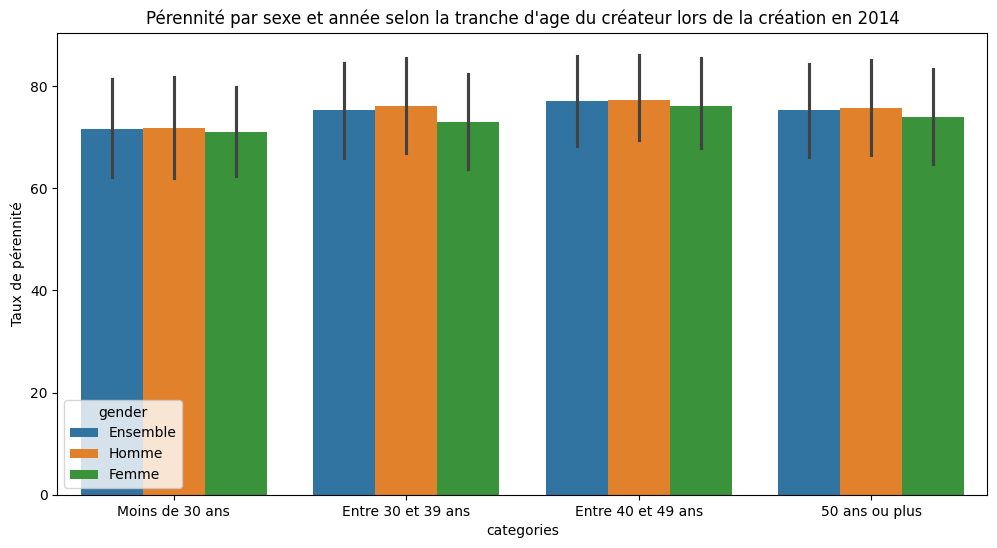

In [91]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_plot,
    x="categories", y="Taux de pérennité", hue="gender"
)

plt.title("Pérennité par sexe et année selon la tranche d'age du créateur lors de la création en 2014")
plt.show()

In [95]:
df_plot_2018 = df_2018[
    (df_2018["categorie_type"] == "Tranche d’âge du créateur en 2018") &
    (df_2018["area"] == "FR") &
    (df_2018["categories"] != "Ensemble")
].copy()

fig = px.bar(
    df_plot_2018,
    x="categories",
    y="Taux de pérennité (%)",
    color="gender",
    animation_frame="years",
    barmode="group",
    labels={"categories": "Tranche d'âge", "gender": "Genre"},
    title="Évolution de la pérennité selon le genre et la tranche d'âge",
)

fig.update_layout(
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    margin=dict(l=40, r=40, t=80, b=80)
)

fig.show()


In [82]:
# Dégradés simples
palette_femme = ["#006D2C", "#31A354", "#A1D99B"]  
palette_homme = ["#08306B", "#2171B5", "#6BAED6"]      
palette_ensemble = ["#99000D", "#CB181D", "#FB6A4A"]   

palettes = {
    "Femme": palette_femme,
    "Homme": palette_homme,
    "Ensemble": palette_ensemble,
}

In [83]:
fig = go.Figure()

# Boucle sur chaque genre
for genre in df_plot["gender"].unique():
    df_genre = df_plot[df_plot["gender"] == genre]
    palette = palettes.get(genre, ["gray", "gray", "gray"])  # fallback sécurité

    # Boucle sur chaque année (1, 2, 3 ans)
    for i, year in enumerate(sorted(df_genre["years"].unique())):
        df_year = df_genre[df_genre["years"] == year]

        fig.add_trace(go.Scatter(
            x=df_year["categories"],
            y=df_year["Taux de pérennité (%)"],
            mode="lines+markers",
            name=f"{genre} - {year}",
            line=dict(color=palette[i], width=2),
            marker=dict(color=palette[i]),
        ))

# Mise en forme
fig.update_layout(
    title="Taux de pérennité selon l'âge du créateur, le genre et l'ancienneté",
    xaxis_title="Tranche d'âge",
    yaxis_title="Taux de pérennité (%)",
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    legend_title="Genre - Année",
    template="plotly_white"
)

fig.show()


lecture du graph : on remarque ici que les femmes ont tendance à créer une entreprise qui perdure dans le temps, peu importe l'âge à laquelle elle créé son entreprise. Le plus haut taux de pérénité au bout de 3 ans reste cependant lorsque la tranche d'âge se trouve entre 40 et 49 ans. (hommes (51%) comme femmes (58%))